# Enabling Observability with OpenTelemetry

Atoti Python API features an observability plugin to integrate OpenTelemetry with Atoti for better monitoring and debugging capabilities. 

In this notebook, we explore how to set up observability for Atoti Python API using OpenTelemetry.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=observability-with-otel" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
# !uv pip install 'atoti[observability]'

In [2]:
import atoti as tt
import zipfile
import wget
from IPython.display import clear_output, display

## Start the OTEL stack

To set up observability for Atoti using OpenTelemetry, we first need a place to send our metrics, logs, and traces.

The `docker-compose.yaml` located in `otel-stack` configures the following multi-container [Docker](https://www.docker.com/) application:

![otel-stack-diagram-2](https://data.atoti.io/notebooks/observability-with-otel/img/otel-stack-diagram-2.png)

With the Atoti Python API observability plugin, Atoti can use OpenTelemetry to instrument its code and generate telemetry data during execution. The telemetry data is then handled by the [OTEL collector](https://opentelemetry.io/docs/collector/) and sent to the corresponding services integrated with [Grafana](https://grafana.com/):

* **Traces:** Exported to [Tempo](https://grafana.com/oss/tempo/) (with OTLP).
* **Logs:** Exported to [Loki](https://grafana.com/oss/loki/) (push to an endpoint).
* **Metrics:** Scraped from the OTEL collector endpoint via [Prometheus](https://grafana.com/oss/prometheus/) every 15 seconds.

Navigate to `otel-stack` and execute the following command to setup and confirm the containers are up and running:

```bash
docker compose up -d
```

💡 **Note:** Use the `docker ps` and `docker logs` commands to verify the containers are healthy.


## Download data

To simulate greater computation in this walk through, we've prepared 2GB worth of trades and books data.

In [3]:
url = f"https://data.atoti.io/notebooks/observability-with-otel/data/data.zip"
filename = wget.download(url)

with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall()

100% [......................................................................] 843205063 / 843205063

## Configure the Atoti session for OpenTelemetry

When using the observability plugin for Atoti Python API, we need to configure the underlying Atoti Server JVM to use OpenTelemetry. 

The following configurations are set as their defaults:

```java
"-Dspring.profiles.active=application-monitoring",
"-Dotel.java.global-autoconfigure.enabled=true",
"-Dotel.traces.exporter=otlp",
"-Dotel.metrics.exporter=otlp",
"-Dotel.logs.exporter=otlp",
"-Dotel.exporter.otlp.endpoint=http://localhost:4318",
"-Dotel.resource.attributes=service.name=atoti,service.version=1.0",
"-Dotel.exporter.otlp.protocol=grpc"
```

The following configurations are user specific:

```java
"-Djson.log.dir=logs",
"-Dotel.traces.sampler=always_on",
"-Dotel.metric.export.interval=1000",

```
    
We can also add in an OpenTelemetry java agent to report more metrics about the performance of the underlying JVM.

```java
"-javaagent:opentelemetry-javaagent.jar"
```


In [4]:
url = f"https://github.com/open-telemetry/opentelemetry-java-instrumentation/releases/latest/download/opentelemetry-javaagent.jar"
filename = wget.download(url)

100% [........................................................................] 21891536 / 21891536

In [5]:
session = tt.Session.start(
    tt.SessionConfig(
        port=9105,
        java_options=[
            "-Dspring.profiles.active=application-monitoring",
            "-Dotel.java.global-autoconfigure.enabled=true",
            "-Dotel.traces.exporter=otlp",
            "-Dotel.metrics.exporter=otlp",
            "-Dotel.logs.exporter=otlp",
            "-Dotel.exporter.otlp.endpoint=http://localhost:4318",
            "-Dotel.resource.attributes=service.name=atoti,service.version=1.0",
            "-Dotel.exporter.otlp.protocol=grpc",
            "-Djson.log.dir=logs",
            "-Dotel.traces.sampler=always_on",
            "-Dotel.metric.export.interval=1000",
            "-javaagent:opentelemetry-javaagent.jar",
        ],
    )
)

## Load data, join data, visualize data model

We then perform the following:

1. Load our data into tables
2. Make the corresponding joins
3. Visualize the data model of the cube

Trades Row Count: 383688
Books Row Count: 408


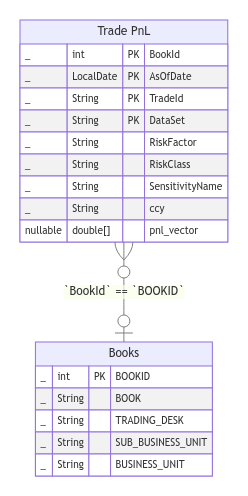

In [6]:
trades_tbl = session.read_csv(
    "data/trades/TradePnLs*.csv",
    table_name="Trade PnL",
    keys=["AsOfDate", "TradeId", "BookId", "DataSet"],
    array_separator=";",
)
books_tbl = session.read_csv(
    "data/books/books_books.csv", table_name="Books", keys=["BOOKID"]
)
trades_tbl.join(books_tbl, trades_tbl["BookId"] == books_tbl["BOOKID"])

cube = session.create_cube(trades_tbl)
h, l, m = cube.hierarchies, cube.levels, cube.measures

print(f"Trades Row Count: {trades_tbl.row_count}")
print(f"Books Row Count: {books_tbl.row_count}")

session.tables.schema

### Computing VaR 95

We have a `pnl_vector.SUM` measure which is the sum of the profit and loss (PnL) value for each historical date.

In [7]:
m

{'pnl_vector.SUM': <atoti.measure.Measure object at 0x10ff9c190>, 'contributors.COUNT': <atoti.measure.Measure object at 0x12802eed0>, 'pnl_vector.MEAN': <atoti.measure.Measure object at 0x12865ff50>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x12865ced0>}

Therefore, we can define the formula for a 95% confidence level [value at risk (VaR)](https://www.investopedia.com/articles/04/092904.asp) measure as follows:

In [8]:
m["VaR95"] = tt.array.quantile(m["pnl_vector.SUM"], 1 - 0.95)

Then, run the query to calculate `Var95` for each `AsOfDate` and `BUSINESS_UNIT`.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
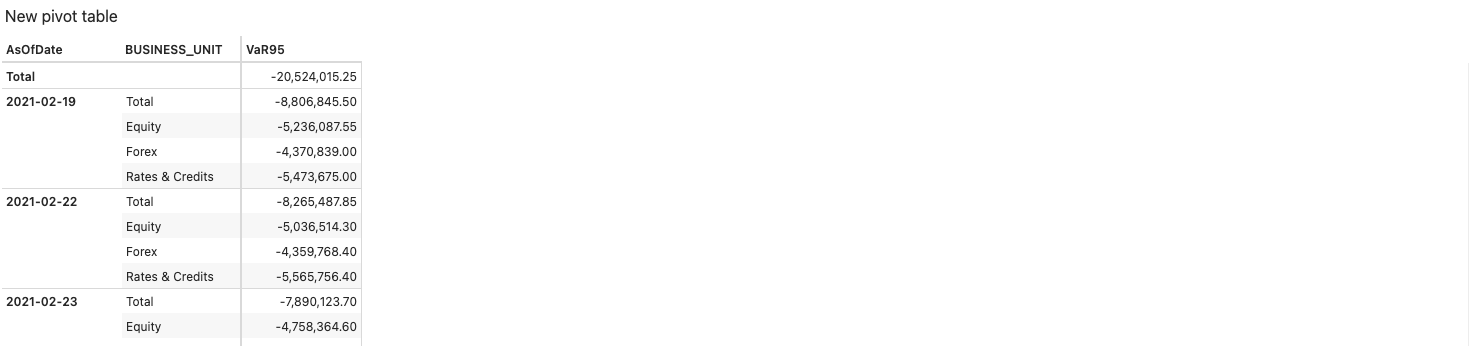

In [9]:
session.widget

## Monitoring Performance

By this point, Atoti has already sent over telemetry data to the OpenTelemetry collector from our previous operations. This data can then be processed and visualized in Grafana using Loki, Tempo, and Prometheus. We can verify that Atoti is generating OpenTelemetry data by navigating to `localhost:3000`. In the left-hand pane, we can visit the *Explore* menu to access our metrics, logs, and traces using Grafana.

### Metrics

Metrics are quantifiable measurements that reflect the behvaior, health, and performance of an application and its infrastructure.

In our setup, Prometheus scrapes the telemetry data exported from Atoti to the OTEL collector and enables us to visualize the Atoti-specific metrics in Grafana. Navigate to the Grafana UI located at [localhost:3000](http://localhost:3000) and click on the *Metrics* item in the left-hand pane to pull up the metric charts.

💡 **Note:** Check out the documentation for more information on [Atoti-specific metrics](https://docs.activeviam.com/products/atoti/server/6.1.0/docs/monitoring/metrics/).

For example, we see various metrics pop up relating to the execution of the notebook, such as loading CSV data into the tables and the resulting table memory footprint. By monitoring the details captured from our metrics, we can better assess the results of our operations in real time.

![metrics](https://data.atoti.io/notebooks/observability-with-otel/img/metrics.png)

Similarly, we can also view the JVM metrics reported by the OpenTelemetry Java agent.

![java-metrics](https://data.atoti.io/notebooks/observability-with-otel/img/java-metrics.png)

## Logs

Logs are the detailed records of events, warnings and errors occurring over time for a software application or system.

Loki is a log aggregation system that natively integrates with Grafana to store and query logs for more effective log management. When we view the Atoti logs in Grafana using Loki, we see the underlying events performed in this notebook: starting the Atoti session, loading data from CSV, creating the cube, and most recently, querying the database using the Atoti JupyterLab widget shown in previous cells.

![logs](https://data.atoti.io/notebooks/observability-with-otel/img/logs-2.png)

Notice that if we click on a single log record, we can also see the underlying fields of the event along with their values. This also allows us to perform filters based on field values, which enhances the investigative abilities when dealing with logs.

![logs-fields](https://data.atoti.io/notebooks/observability-with-otel/img/logs-fields.png)

## Traces

Traces help us understand the flow of requests and interactions within a system. They are the detailed records of how a request flows through a system, tracking its journey across different components, services, or processes. Traces are made up of one or more spans. A span represents a single operation within that request, providing detailed information about that specific step in the request flow.

With the observability plugin, we can visualize our traces in Grafana using Tempo. Tempo is a distributed tracing backend that natively integrates with Grafana and allows us to visualize the interactions of our requests when we use Atoti.

If we select one of the logs relating to the `VaR95` query executed in previous cells, we can pinpoint its `TraceID` and visualize the request flow when querying the Atoti database using the Atoti JupyterLab widget.

![logs-traceid](https://data.atoti.io/notebooks/observability-with-otel/img/logs-traceid-2.png)

Using these insights we are able to determine the time it takes for a request to complete at every stage of its journey across the system. Should any problems arise, this granular view helps us better diagnose issues.

![traceid-spans](https://data.atoti.io/notebooks/observability-with-otel/img/traceid-spans-2.png)

## Monitoring aggregate providers

A common use case in Atoti is to use aggregate providers to speed up queries. Aggregate providers pre-compute and store aggregates for the specified granularity for certain hierarchies. These intermediate aggregates are then stored in-memory and used to improve query performance, though at the cost of a higher memory footprint.

💡 **Note:** Take a look at the [aggregate providers](../aggregate-provider/main.ipynb) notebook for a better understanding of how to use aggregate providers.

Let's use the observability plugin for Atoti Python API to monitor the creation and use of an aggregate provider. We'll use the `query` function with the `%%time` magic command to get a second opinion of how long it takes the query to return the results for the `VaR95` calculation at the specified granularity.

In [10]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
)

CPU times: user 26 ms, sys: 9.44 ms, total: 35.4 ms
Wall time: 192 ms


VaR95
BUSINESS_UNIT   SUB_BUSINESS_UNIT       TRADING_DESK                
Equity          Foreign Equity          Hermes        -15,619,158.90
Forex           Developed Market        Hades         -11,124,911.55
Rates & Credits Domestic Rates & Credit Hermes        -14,847,674.25
                                        Keres          -9,981,765.60

When we re-visit Grafana and Tempo and monitor the trace for the query, we can see the corresponding breakdown of spans for each of the underlying services that were impacted.

💡 **Note:** The time taken produced by `%%time` may differ from what is shown in the corresponding TraceID diagram. This is because `%%time` measures the execution time of the notebook cell entirely, whereas the TraceID measures the execution time of a request traveling through the system.

![before-aggregate-provider](https://data.atoti.io/notebooks/observability-with-otel/img/before-aggregate-provider.png)

Let's now create our aggregate provider to match the granularity of the previous query for the `pnl_vector.SUM` measure. This pre-computes and stores the intermediate aggregate for `pnl_vector.SUM` at the specified granularity and improves the query time when calculating `VaR95`.

In [11]:
cube.aggregate_providers.update(
    {
        "PnL provider": tt.AggregateProvider(
            key="bitmap",
            levels=[
                l["BUSINESS_UNIT"],
                l["SUB_BUSINESS_UNIT"],
                l["TRADING_DESK"],
            ],
            measures=[m["pnl_vector.SUM"]],
        )
    }
)

Then, re-run the query.

In [12]:
%%time
cube.query(
    m["VaR95"],
    levels=[l["BUSINESS_UNIT"], l["SUB_BUSINESS_UNIT"], l["TRADING_DESK"]],
)

CPU times: user 10.1 ms, sys: 2.28 ms, total: 12.4 ms
Wall time: 65.2 ms


VaR95
BUSINESS_UNIT   SUB_BUSINESS_UNIT       TRADING_DESK                
Equity          Foreign Equity          Hermes        -15,619,158.90
Forex           Developed Market        Hades         -11,124,911.55
Rates & Credits Domestic Rates & Credit Hermes        -14,847,674.25
                                        Keres          -9,981,765.60

We see from the `%%time` magic command that query times have improved thanks to the aggregate provider. In addition, when we view the corresponding TraceID in Grafana and Tempo, we can visualize the granular improvement for the request. For example, we see that the overall time for the trace/request has significantly improved, while the granular spans also show an increase in performance.

![after-aggregate-provider](https://data.atoti.io/notebooks/observability-with-otel/img/after-aggregate-provider.png)

This walk through was just a small example of how to get observability up and running with OpenTelemetry using the Atoti observability plugin. However, perfomance tuning and monitoring are useful and relevant at any stage of an Atoti project. It's a good idea to set them up during initial stages, so that when the project is ready to scale we have everything we need already in place.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=observability-with-otel" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>